# Nelder-Mead Generator adapted from SciPy

Most of the algorithms in scipy.optimize are self-contained functions that operate on the user-provided `func`. Xopt has adapted the Nelder-Mead directly from scipy.optimize to be in a generator form. This allows for the manual stepping through the algorithm.


In [1]:
from xopt.generators.sequential.neldermead import NelderMeadGenerator
from xopt import Evaluator, VOCS
from xopt.resources.test_functions.rosenbrock import rosenbrock

import pandas as pd

from xopt import Xopt
import numpy as np

from scipy.optimize import fmin

# from xopt import output_notebook
# output_notebook()

import matplotlib.pyplot as plt

## Nelder-Mead optimization of the Rosenbrock function with Xopt

In [36]:
YAML = """
generator:
  name: neldermead
  adaptive: true
  xatol: 0.0001
  fatol: 0.0001  
evaluator:
  function: xopt.resources.test_functions.rosenbrock.evaluate_rosenbrock
vocs:
  variables:
    x0: [-5, 5]
    x1: [-5, 5]
  objectives: {y: MINIMIZE}
"""
X = Xopt.from_yaml(YAML)

In [37]:
XMIN = [1, 1]  # True minimum

In [38]:
X.random_evaluate(2)
X.run()
X.data

,x0,x1,y,xopt_runtime,xopt_error
0,-2.025248,-1.067219,2.680851e+03,0.000010,False
1,-0.753865,-3.833633,1.940789e+03,0.000003,False
2,-0.753865,-3.833633,1.940789e+03,0.000008,False
3,-0.791558,-3.833633,1.992546e+03,0.000010,False
4,-0.753865,-4.025315,2.113217e+03,0.000009,False
...,...,...,...,...,...
184,0.999975,0.999949,6.483504e-10,0.000006,False
185,0.999879,0.999760,1.502293e-08,0.000006,False
186,1.000011,1.000023,2.504473e-10,0.000006,False
187,1.000026,1.000051,8.816835e-10,0.000006,False


Text(0, 0.5, 'Rosenbrock value')

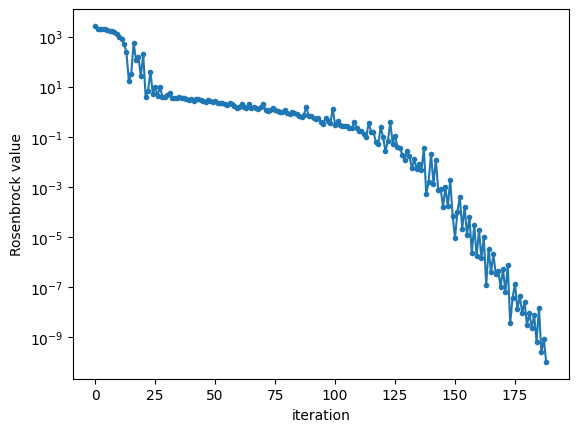

In [39]:
# Evaluation progression
X.data["y"].plot(marker=".")
plt.yscale("log")
plt.xlabel("iteration")
plt.ylabel("Rosenbrock value")

In [6]:
# Minimum
dict(X.data.iloc[X.data["y"].argmin()])

{'x0': np.float64(1.0000181329366322),
 'x1': np.float64(1.0000351774434568),
 'y': np.float64(4.4734292222064314e-10),
 'xopt_runtime': np.float64(8.200004231184721e-06),
 'xopt_error': np.False_}

## Visualize

Text(0.5, 1.0, "Xopt's Nelder-Mead progression")

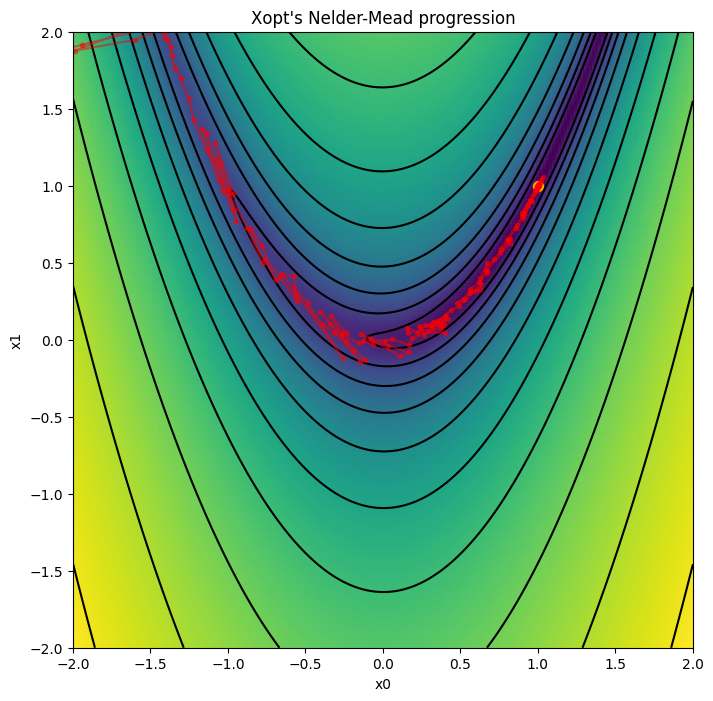

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))

Xgrid, Ygrid = np.meshgrid(np.linspace(-2, 2, 201), np.linspace(-2, 2, 201))

Zgrid = np.vectorize(lambda x, y: rosenbrock([x, y]))(Xgrid, Ygrid)
Zgrid = np.log(Zgrid + 1)

ax.pcolormesh(Xgrid, Ygrid, Zgrid)
ax.contour(Xgrid, Ygrid, Zgrid, levels=10, colors="black")
ax.set_xlabel("x0")
ax.set_ylabel("x1")


# Add all evaluations
ax.plot(X.data["x0"], X.data["x1"], color="red", alpha=0.5, marker=".")
ax.scatter(XMIN[0], XMIN[1], 50, marker="o", color="orange", label="True minimum")
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
# plt.legend()
ax.set_title("Xopt's Nelder-Mead progression")

In [8]:
# Manually step the algorithm and collect simplexes
X = Xopt.from_yaml(YAML)
simplexes = []
while not X.generator.is_done:
    X.step()
    simplexes.append(X.generator.simplex)

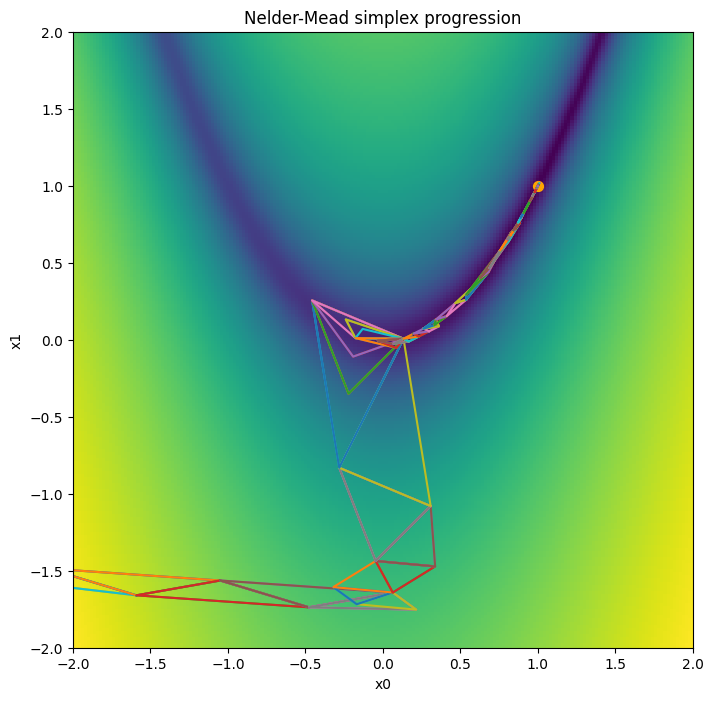

In [9]:
def plot_simplex(simplex, ax=None):
    x0 = simplex["x0"]
    x1 = simplex["x1"]
    x0 = np.append(x0, x0[0])
    x1 = np.append(x1, x1[0])
    ax.plot(x0, x1)


fig, ax = plt.subplots(figsize=(8, 8))
ax.pcolormesh(Xgrid, Ygrid, Zgrid)
# ax.contour(Xgrid, Ygrid, Zgrid, levels=10, colors='black')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_xlabel("x0")
ax.set_ylabel("x1")
ax.set_title("Nelder-Mead simplex progression")

ax.scatter(XMIN[0], XMIN[1], 50, marker="o", color="orange", label="True minimum")

for simplex in simplexes:
    plot_simplex(simplex, ax)

## Compare with scipy.optimize.fmin Nelder-Mead

Notice that fmin is much faster here. This is because the function runs very fast, so the internal Xopt bookkeeping overhead dominates.


In [10]:
result = fmin(rosenbrock, [-1, -1])
result

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 67
         Function evaluations: 125


array([0.99999886, 0.99999542])

In [11]:
X = Xopt.from_yaml(YAML)

In [12]:
X.run()
# Almost exactly the same number evaluations.
len(X.data)

138

In [13]:
# results are the same
xbest = X.data.iloc[X.data["y"].argmin()]
xbest["x0"] == result[0], xbest["x1"] == result[1]

(np.False_, np.False_)

# NelderMeadGenerator object

In [14]:
NelderMeadGenerator.model_fields

{'supports_batch_generation': FieldInfo(annotation=bool, required=False, default=False, description='flag that describes if this generator can generate batches of points', exclude=True, frozen=True),
 'supports_multi_objective': FieldInfo(annotation=bool, required=False, default=False, description='flag that describes if this generator can solve multi-objective problems', exclude=True, frozen=True),
 'vocs': FieldInfo(annotation=VOCS, required=True, description='generator VOCS', exclude=True),
 'data': FieldInfo(annotation=Union[DataFrame, NoneType], required=False, default=None, description='generator data', exclude=True),
 'is_active': FieldInfo(annotation=bool, required=False, default=False),
 'initial_point': FieldInfo(annotation=Union[Dict[str, float], NoneType], required=False, default=None),
 'initial_simplex': FieldInfo(annotation=Union[Dict[str, Union[List[float], ndarray]], NoneType], required=False, default=None),
 'adaptive': FieldInfo(annotation=bool, required=False, defau

In [15]:
Xbest = [33, 44]


def f(inputs, verbose=False):
    if verbose:
        print(f"evaluate f({inputs})")
    x0 = inputs["x0"]
    x1 = inputs["x1"]

    # if x0 < 10:
    #    raise ValueError('test XXXX')

    y = (x0 - Xbest[0]) ** 2 + (x1 - Xbest[1]) ** 2

    return {"y": y}


ev = Evaluator(function=f)
vocs = VOCS(
    variables={"x0": [-100, 100], "x1": [-100, 100]}, objectives={"y": "MINIMIZE"}
)
vocs.json()

'{"variables":{"x0":[-100.0,100.0],"x1":[-100.0,100.0]},"constraints":{},"objectives":{"y":"MINIMIZE"},"constants":{},"observables":[]}'

In [16]:
# check output
f(vocs.random_inputs()[0])

{'y': 14879.9160540806}

In [17]:
G = NelderMeadGenerator(vocs=vocs)
inputs = G.generate(1)
inputs

[{'x0': np.float64(76.78486473065846), 'x1': np.float64(-45.02532290207586)}]

In [18]:
# Further generate calls will continue to produce same point, as with BO
G.generate(1)

[{'x0': np.float64(76.78486473065846), 'x1': np.float64(-45.02532290207586)}]

In [19]:
ev.evaluate(inputs[0])

{'y': np.float64(9842.62249730093),
 'xopt_runtime': 8.90000956133008e-06,
 'xopt_error': False}

In [20]:
# Adding new data will advance state to next step, and next generate() will yield new point
G.add_data(pd.DataFrame([ev.evaluate(inputs[0])]))
G.generate(1)

KeyError: "None of [Index(['x0', 'x1'], dtype='object')] are in the [columns]"

In [ ]:
# Create Xopt object
X = Xopt(evaluator=ev, vocs=vocs, generator=NelderMeadGenerator(vocs=vocs))

# Optional: give an initial pioint
X.generator.initial_point = {"x0": 0, "x1": 0}

In [ ]:
X.run()

In [ ]:
# Generator is done and cannot be resumed
X.generator.is_done

In [ ]:
# Generate calls will just return nothing
X.generator.generate(1) is None

In [ ]:
# This shows the latest simplex
X.generator.simplex

In [ ]:
X.data["y"].plot()
plt.yscale("log")

In [ ]:
fig, ax = plt.subplots()
X.data.plot("x0", "x1", ax=ax, color="black", alpha=0.5)
ax.scatter(Xbest[0], Xbest[1], marker="x", color="red")

In [ ]:
# This is the raw internal state of the generator
a = X.generator.current_state
a

In [ ]:
# Check JSON representation of options
X.generator.json()

In [ ]:
# Set the initial simplex to be the latest
X2 = Xopt(
    evaluator=ev,
    vocs=vocs,
    generator=NelderMeadGenerator(vocs=vocs, initial_simplex=X.generator.simplex),
)
X2.generator.xatol = 1e-9
X2.generator.fatol = 1e-9
X2.run()

X2.data["y"].plot()
plt.yscale("log")

## 5-dimensional Rosenbrock

`evaluate_rosenbrock` works for arbitrary dimensions, so adding more variables to `vocs` transforms this problem.

In [ ]:
YAML = """
generator:
  name: neldermead
evaluator:
  function: xopt.resources.test_functions.rosenbrock.evaluate_rosenbrock
vocs:
  variables:
    x1: [-5, 5]
    x2: [-5, 5]
    x3: [-5, 5]
    x4: [-5, 5]
    x5: [-5, 5]
  objectives:
    y: MINIMIZE
"""
X = Xopt.from_yaml(YAML)

In [ ]:
X.run()
X.data["y"].plot()
plt.yscale("log")

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

Xgrid, Ygrid = np.meshgrid(np.linspace(-2, 2, 201), np.linspace(-2, 2, 201))

Zgrid = np.vectorize(lambda x, y: rosenbrock([x, y, 1, 1, 1]))(
    Xgrid, Ygrid
)  # The minimum is at 1,1,1,1,1
Zgrid = np.log(Zgrid + 1)

ax.pcolormesh(Xgrid, Ygrid, Zgrid)
ax.contour(Xgrid, Ygrid, Zgrid, levels=10, colors="black")
ax.set_xlabel("x0")
ax.set_ylabel("x1")


# Add all evaluations
ax.plot(X.data["x1"], X.data["x2"], color="red", alpha=0.5, marker=".")
ax.scatter(XMIN[0], XMIN[1], 50, marker="o", color="orange", label="True minimum")
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
# plt.legend()
ax.set_title("Xopt's Nelder-Mead progression")